In [52]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

from utils.losses import focalSoftMSE

In [83]:

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=32, optimizer_generator = Adam(0.00005, beta_1=.5), 
                optimizer_discriminator = Adam(0.00001, beta_1=.5), optimizer_autoencoder = Adam(0.001, beta_1=.9)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        #encoder.add(GlobalAvgPool3D())
#         encoder.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
#         encoder.add(Flatten())
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
#         decoder.add(Dense(512, activation='relu', input_dim=encoded_dim))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(512, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(6*12*12, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         #decoder.add(Reshape([12*24*24,1]))
#         #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
#         #decoder.add(Permute((2,1)))
#         decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(512, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(512, activation="relu"))
        discriminator.add(Dense(64, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")
        
        discriminator = None
        generator = None
#         discriminator=self._buildDiscriminator(encoded_dim)
#         discriminator.trainable = False
#         generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
#         generator.compile(optimizer=optimizer_generator, loss="mse")
#         discriminator.trainable = True
#         discriminator.compile(optimizer=optimizer_discriminator, loss="mse")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(autoencoder_input, discriminator2(autoencoder(autoencoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="mse")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="mse")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
#             discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
#             discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history=0
            generator_history=0
            
            #discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            #generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(x, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)
            
            if epoch == 1:
                loss_min = autoencoder_history
                loss_min_epoch = 1
            
            if epoch > 5 and autoencoder_history < loss_min:
                loss_min = autoencoder_history
                loss_min_epoch = epoch
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
                
            
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  AE_loss_min: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, loss_min, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        print("Min_loss at epoch: {}".format(loss_min_epoch))
        print("Best model saved at: ../GAN_log/autoencoder_epoch_{}.h5".format(loss_min_epoch))
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [21]:
import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../Training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 86.16it/s]


In [85]:
model = AAE(encoded_dim=256)

batch_size=16
n_epochs=6000
seed=42
np.random.seed(42)


In [ ]:
history = model.train(train_set, batch_size, n_epochs, len(img_ls))

Epoch--1
AE_loss: 0.7904  AE_loss_min: 0.7904  D1_loss:0.000   D2_loss:0.251   G1_loss:0.000   G2_loss:0.261
Epoch--2
AE_loss: 0.3342  AE_loss_min: 0.7904  D1_loss:0.000   D2_loss:0.251   G1_loss:0.000   G2_loss:0.254
Epoch--3
AE_loss: 0.0933  AE_loss_min: 0.7904  D1_loss:0.000   D2_loss:0.251   G1_loss:0.000   G2_loss:0.252


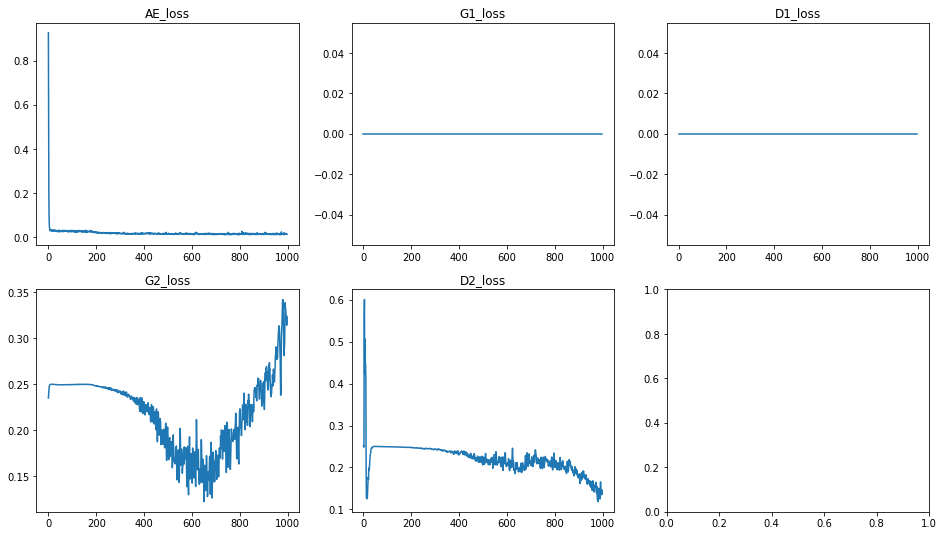

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [81]:
image = train_set[-38].reshape((1,48,96,96,1))
model.autoencoder.load_weights(r'../GAN_log/autoencoder_epoch_62.h5')
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

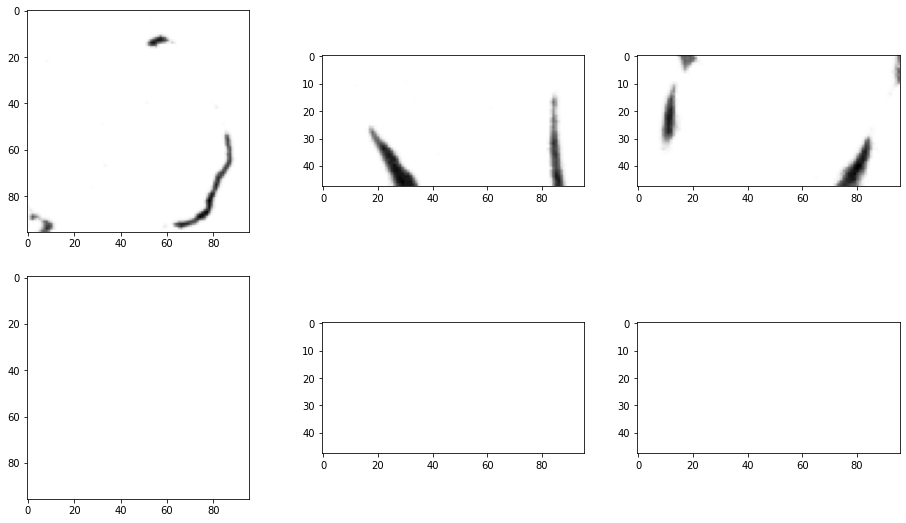

In [82]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [60]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_136 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_137 (Conv3D)          (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 48, 48, 16)    64        
_________________________________________________________________
conv3d_138 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
batch_normalization_27 (Batc (None, 24, 48, 48, 32)    128       
_________________________________________________________________
conv3d_139 (Conv3D)          (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
batch_normalization_28 (Batc (None, 12, 24, 24, 32)  

In [61]:
model.decoder.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_136 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_137 (Dense)            (None, 864)               443232    
_________________________________________________________________
reshape_11 (Reshape)         (None, 6, 12, 12, 1)      0         
_________________________________________________________________
conv3d_transpose_88 (Conv3DT (None, 6, 12, 12, 128)    3584      
_________________________________________________________________
batch_normalization_32 (Batc (None, 6, 12, 12, 128)    512       
_________________________________________________________________
conv3d_transpose_89 (Conv3DT (None, 6, 12, 12, 64)   

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________
